## 1. Setup

In [1]:

import os
import json
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score
)

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

Device: cuda
GPU: Tesla T4


## 2. Exploratory Data Analysis

In [2]:
DATA_DIR    = Path('/kaggle/input/cataractdataset/dataset')
CLASSES     = ['1_normal', '2_cataract']
CLASS_NAMES = ['Normal', 'Cataract']
IMG_SIZE    = 224
BATCH_SIZE  = 32
EPOCHS      = 20
LR          = 1e-4
COLORS      = ['#2196F3', '#FF5722']

records = []
for label_idx, folder in enumerate(CLASSES):
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.bmp'):
        for img_path in (DATA_DIR / folder).glob(ext):
            records.append({'path': str(img_path), 'label': label_idx, 'class': CLASS_NAMES[label_idx]})

df = pd.DataFrame(records)
print(f'Total images: {len(df)}')
print(df['class'].value_counts())

Total images: 400
class
Normal      300
Cataract    100
Name: count, dtype: int64


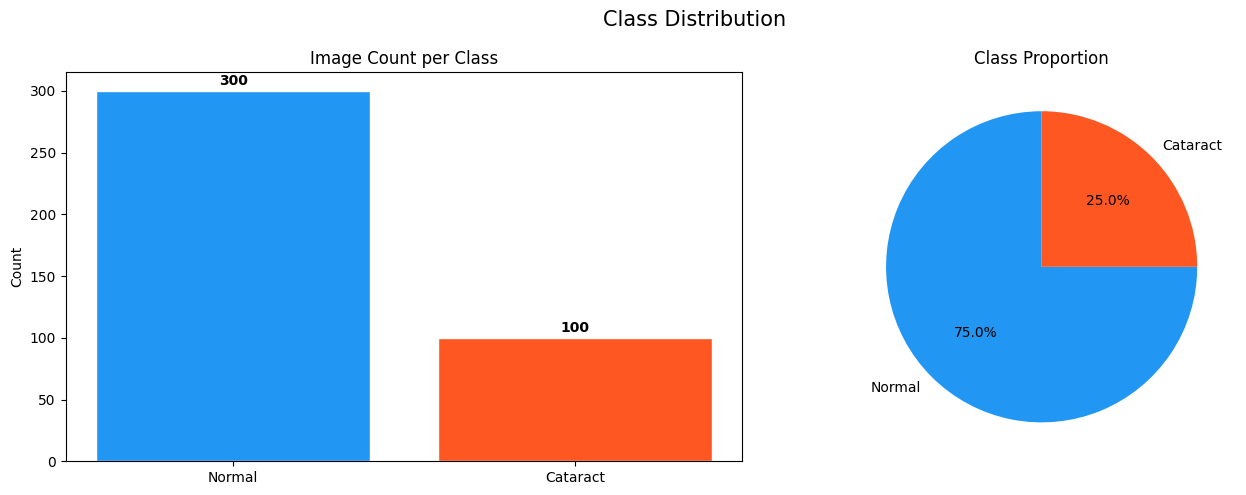

Imbalance ratio: 3.00x
Class imbalance detected — WeightedRandomSampler will be used.


In [3]:
counts = df['class'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Class Distribution', fontsize=15)

bars = axes[0].bar(counts.index, counts.values, color=COLORS, edgecolor='white')
axes[0].set_title('Image Count per Class')
axes[0].set_ylabel('Count')
for bar, count in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
                 str(count), ha='center', va='bottom', fontweight='bold')

axes[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=COLORS, startangle=90)
axes[1].set_title('Class Proportion')

plt.tight_layout()
plt.show()

ratio = counts.max() / counts.min()
print(f'Imbalance ratio: {ratio:.2f}x')
if ratio > 1.5:
    print('Class imbalance detected — WeightedRandomSampler will be used.')

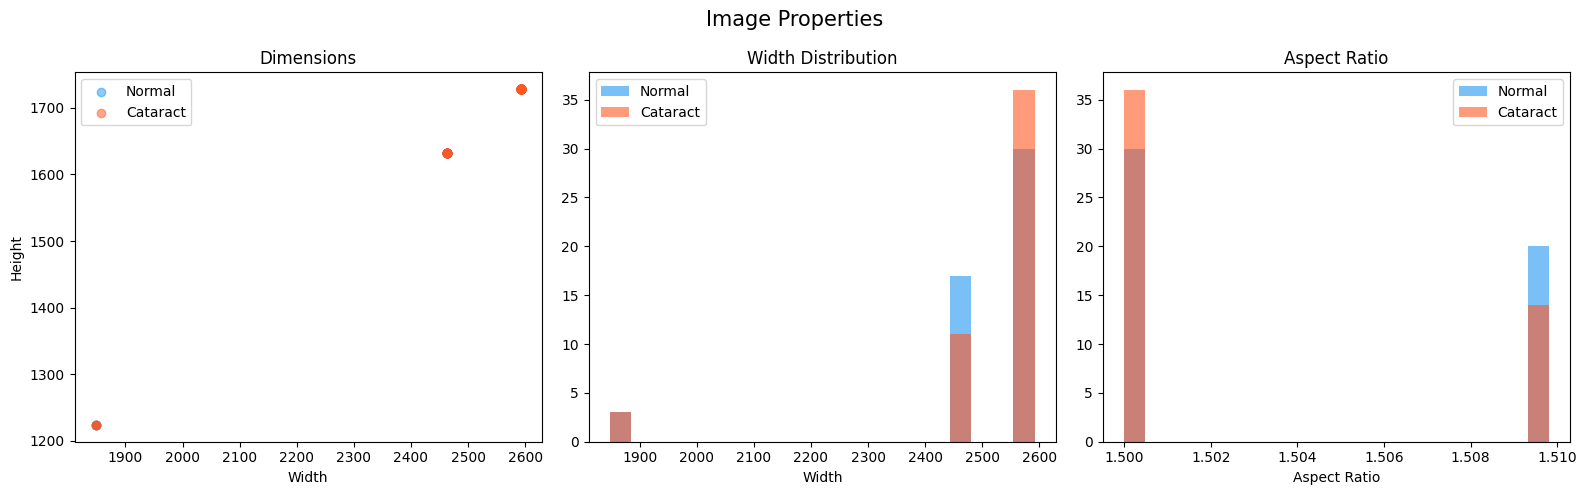

         width                                                        height  \
         count    mean    std     min     25%     50%     75%     max  count   
class                                                                          
Cataract  50.0  2519.2  179.3  1848.0  2464.0  2592.0  2592.0  2592.0   50.0   
Normal    50.0  2503.8  177.9  1848.0  2464.0  2592.0  2592.0  2592.0   50.0   

                                                                 
            mean    std     min     25%     50%     75%     max  
class                                                            
Cataract  1676.6  122.2  1224.0  1632.0  1728.0  1728.0  1728.0  
Normal    1665.1  121.3  1224.0  1632.0  1728.0  1728.0  1728.0  


In [4]:
sample_df = df.groupby('class').apply(lambda x: x.sample(min(50, len(x)), random_state=SEED)).reset_index(drop=True)

props = []
for _, row in sample_df.iterrows():
    try:
        img = Image.open(row['path'])
        w, h = img.size
        props.append({'class': row['class'], 'width': w, 'height': h, 'aspect_ratio': w / h})
    except Exception:
        pass

props_df = pd.DataFrame(props)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Image Properties', fontsize=15)

for cls, color in zip(CLASS_NAMES, COLORS):
    sub = props_df[props_df['class'] == cls]
    axes[0].scatter(sub['width'], sub['height'], alpha=0.5, label=cls, color=color)
axes[0].set_xlabel('Width'); axes[0].set_ylabel('Height'); axes[0].set_title('Dimensions'); axes[0].legend()

for cls, color in zip(CLASS_NAMES, COLORS):
    axes[1].hist(props_df[props_df['class'] == cls]['width'], bins=20, alpha=0.6, label=cls, color=color)
axes[1].set_xlabel('Width'); axes[1].set_title('Width Distribution'); axes[1].legend()

for cls, color in zip(CLASS_NAMES, COLORS):
    axes[2].hist(props_df[props_df['class'] == cls]['aspect_ratio'], bins=20, alpha=0.6, label=cls, color=color)
axes[2].set_xlabel('Aspect Ratio'); axes[2].set_title('Aspect Ratio'); axes[2].legend()

plt.tight_layout()
plt.show()
print(props_df.groupby('class')[['width', 'height']].describe().round(1))

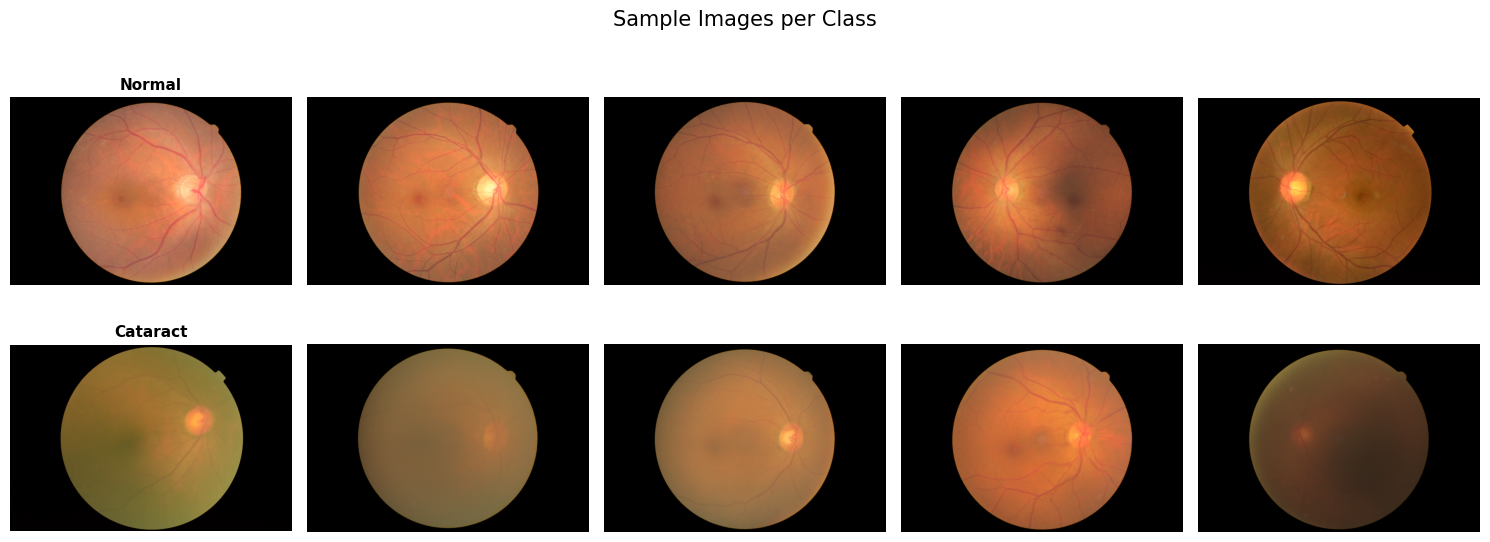

In [5]:
def show_sample_images(df, n_per_class=5):
    fig, axes = plt.subplots(len(CLASS_NAMES), n_per_class, figsize=(3 * n_per_class, 3 * len(CLASS_NAMES)))
    fig.suptitle('Sample Images per Class', fontsize=15)
    for row_idx, cls_name in enumerate(CLASS_NAMES):
        samples = df[df['class'] == cls_name].sample(n_per_class, random_state=SEED)
        for col_idx, (_, sample) in enumerate(samples.iterrows()):
            ax = axes[row_idx][col_idx]
            ax.imshow(Image.open(sample['path']).convert('RGB'))
            ax.axis('off')
            if col_idx == 0:
                ax.set_title(cls_name, fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_sample_images(df)

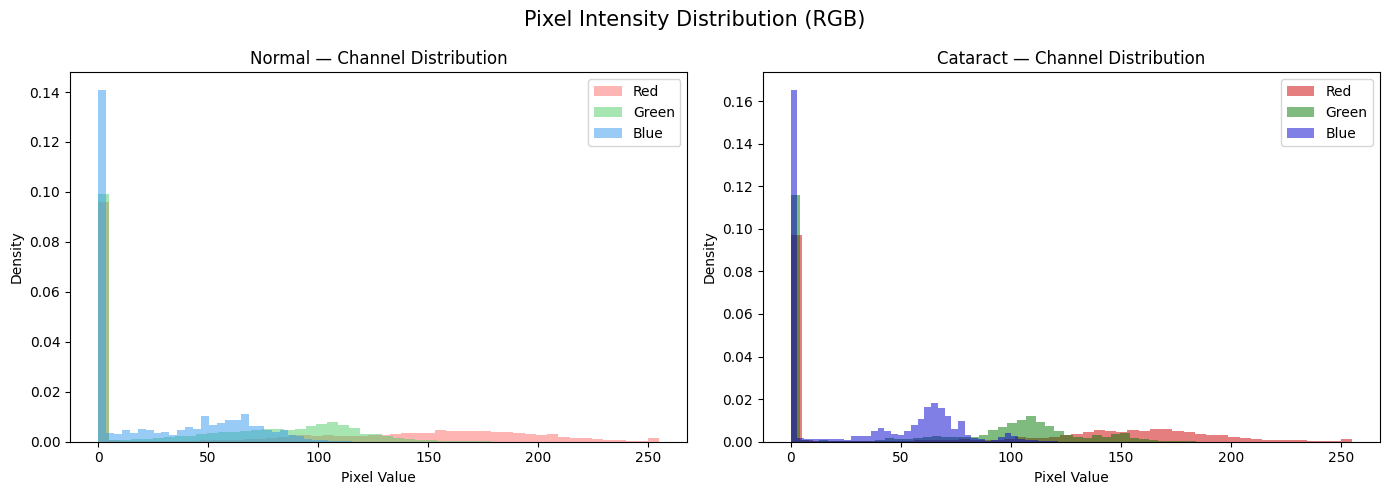

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Pixel Intensity Distribution (RGB)', fontsize=15)

channel_labels = ['Red', 'Green', 'Blue']
channel_colors = {'Normal': ['#FF6B6B', '#51CF66', '#339AF0'], 'Cataract': ['#CC0000', '#007700', '#0000CC']}

for ax_idx, cls_name in enumerate(CLASS_NAMES):
    samples = df[df['class'] == cls_name].sample(min(20, len(df[df['class'] == cls_name])), random_state=SEED)
    pixels  = {c: [] for c in range(3)}
    for _, row in samples.iterrows():
        arr = np.array(Image.open(row['path']).convert('RGB').resize((64, 64)))
        for c in range(3):
            pixels[c].extend(arr[:, :, c].flatten().tolist())
    for c, label in enumerate(channel_labels):
        axes[ax_idx].hist(pixels[c], bins=50, alpha=0.5, label=label,
                          color=channel_colors[cls_name][c], density=True)
    axes[ax_idx].set_title(f'{cls_name} — Channel Distribution')
    axes[ax_idx].set_xlabel('Pixel Value'); axes[ax_idx].set_ylabel('Density')
    axes[ax_idx].legend()

plt.tight_layout()
plt.show()

## 3. Preprocessing & Augmentation

In [7]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)

print(f'Train: {len(train_df)}  Val: {len(val_df)}  Test: {len(test_df)}')
print(train_df['class'].value_counts())

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

Train: 320  Val: 40  Test: 40
class
Normal      240
Cataract     80
Name: count, dtype: int64


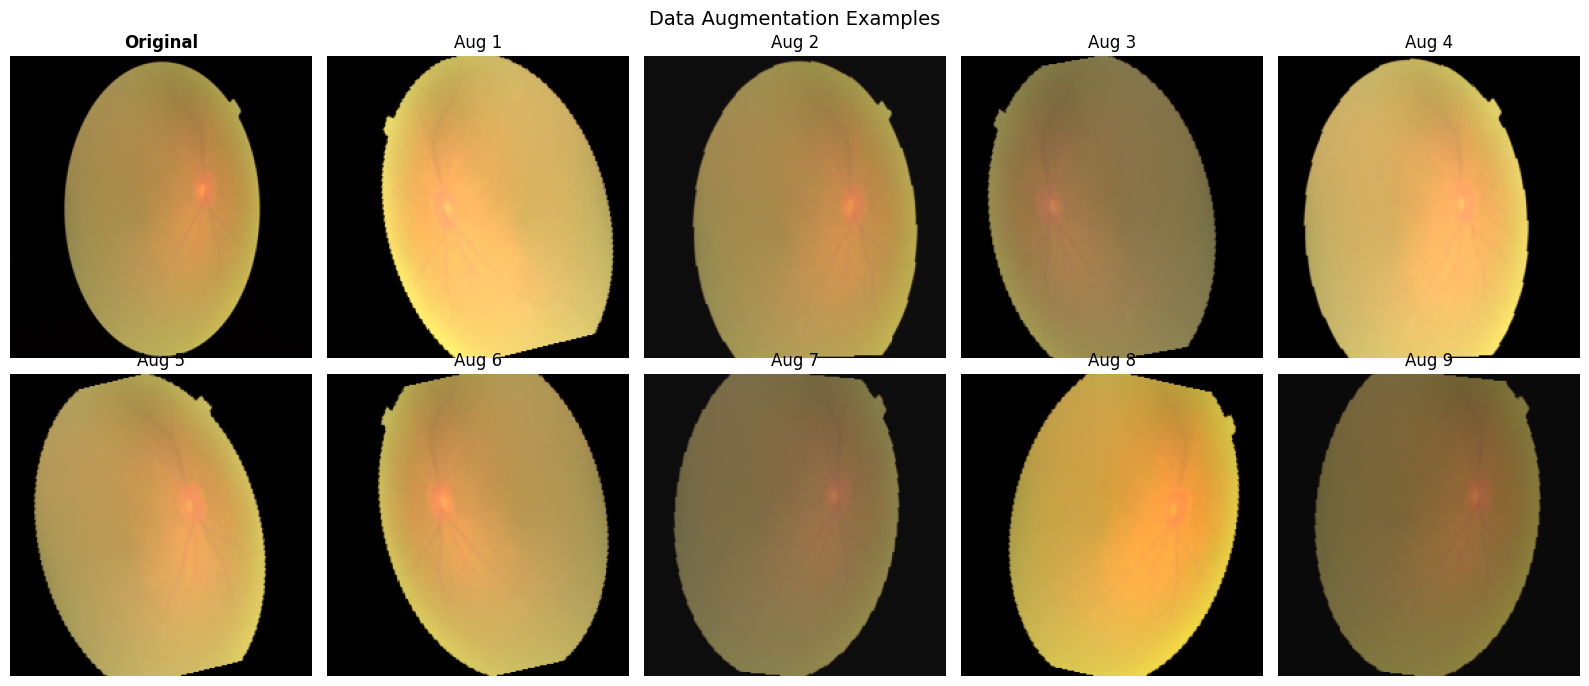

In [8]:
aug_preview = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2)
])

sample_img = Image.open(df[df['class'] == 'Cataract'].iloc[0]['path']).convert('RGB')

fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('Data Augmentation Examples', fontsize=14)

axes[0][0].imshow(sample_img.resize((IMG_SIZE, IMG_SIZE)))
axes[0][0].set_title('Original', fontweight='bold')
axes[0][0].axis('off')

for i in range(1, 10):
    r, c = divmod(i, 5)
    axes[r][c].imshow(aug_preview(sample_img))
    axes[r][c].set_title(f'Aug {i}')
    axes[r][c].axis('off')

plt.tight_layout()
plt.show()

In [9]:
class EyeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df        = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        image = Image.open(row['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, row['label']


class_counts   = train_df['label'].value_counts().sort_index().values
class_weights  = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_df['label']]
sampler        = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataset = EyeDataset(train_df, transform=train_transforms)
val_dataset   = EyeDataset(val_df,   transform=val_transforms)
test_dataset  = EyeDataset(test_df,  transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Train batches: {len(train_loader)}  Val: {len(val_loader)}  Test: {len(test_loader)}')

Train batches: 10  Val: 2  Test: 2


## 4. Model

In [10]:
class CataractClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True, dropout=0.4):
        super().__init__()
        self.backbone   = timm.create_model('efficientnet_b3', pretrained=pretrained, num_classes=0)
        in_features     = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.backbone(x))


model = CataractClassifier(num_classes=2, pretrained=True).to(DEVICE)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total params:     {total_params:,}')
print(f'Trainable params: {trainable_params:,}')

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Total params:     11,550,378
Trainable params: 11,550,378


## 5. Training

In [11]:
weights_tensor = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        correct    += (outputs.argmax(dim=1) == labels).sum().item()
        total      += labels.size(0)
    return total_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss    = criterion(outputs, labels)
            probs   = torch.softmax(outputs, dim=1)[:, 1]
            total_loss += loss.item() * images.size(0)
            correct    += (outputs.argmax(dim=1) == labels).sum().item()
            total      += labels.size(0)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    auc = roc_auc_score(all_labels, all_probs)
    return total_loss / total, correct / total, auc


history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': []}
best_val_auc    = 0
best_model_path = '/kaggle/working/best_model.pth'

print(f'{"Epoch":>6} | {"Train Loss":>10} | {"Train Acc":>9} | {"Val Loss":>8} | {"Val Acc":>7} | {"Val AUC":>7}')
print('-' * 65)

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc         = train_one_epoch(model, train_loader, criterion, optimizer)
    vl_loss, vl_acc, vl_auc = evaluate(model, val_loader, criterion)
    scheduler.step()

    history['train_loss'].append(tr_loss)
    history['val_loss'].append(vl_loss)
    history['train_acc'].append(tr_acc)
    history['val_acc'].append(vl_acc)
    history['val_auc'].append(vl_auc)

    flag = ' *' if vl_auc > best_val_auc else ''
    if vl_auc > best_val_auc:
        best_val_auc = vl_auc
        torch.save(model.state_dict(), best_model_path)

    print(f'{epoch:>6} | {tr_loss:>10.4f} | {tr_acc:>8.2%} | {vl_loss:>8.4f} | {vl_acc:>6.2%} | {vl_auc:>7.4f}{flag}')

print(f'\nBest Val AUC: {best_val_auc:.4f}')

 Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Val AUC
-----------------------------------------------------------------
     1 |     0.5694 |   59.06% |   0.6696 | 87.50% |  0.8133 *
     2 |     0.4112 |   79.38% |   0.5634 | 95.00% |  0.8700 *
     3 |     0.3110 |   84.69% |   0.4568 | 90.00% |  0.8633
     4 |     0.2956 |   86.25% |   0.4099 | 87.50% |  0.8800 *
     5 |     0.2479 |   85.94% |   0.4125 | 87.50% |  0.8900 *
     6 |     0.2640 |   85.00% |   0.3973 | 87.50% |  0.9000 *
     7 |     0.2500 |   87.19% |   0.3978 | 87.50% |  0.9100 *
     8 |     0.2242 |   88.12% |   0.4324 | 90.00% |  0.9100 *
     9 |     0.2136 |   88.12% |   0.4458 | 90.00% |  0.9133 *
    10 |     0.2331 |   88.44% |   0.4094 | 90.00% |  0.9200 *
    11 |     0.2015 |   90.00% |   0.4089 | 90.00% |  0.9233 *
    12 |     0.1657 |   88.75% |   0.3926 | 90.00% |  0.9300 *
    13 |     0.2119 |   87.19% |   0.3932 | 90.00% |  0.9233
    14 |     0.1873 |   90.94% |   0.4147 | 90.00% |  0.

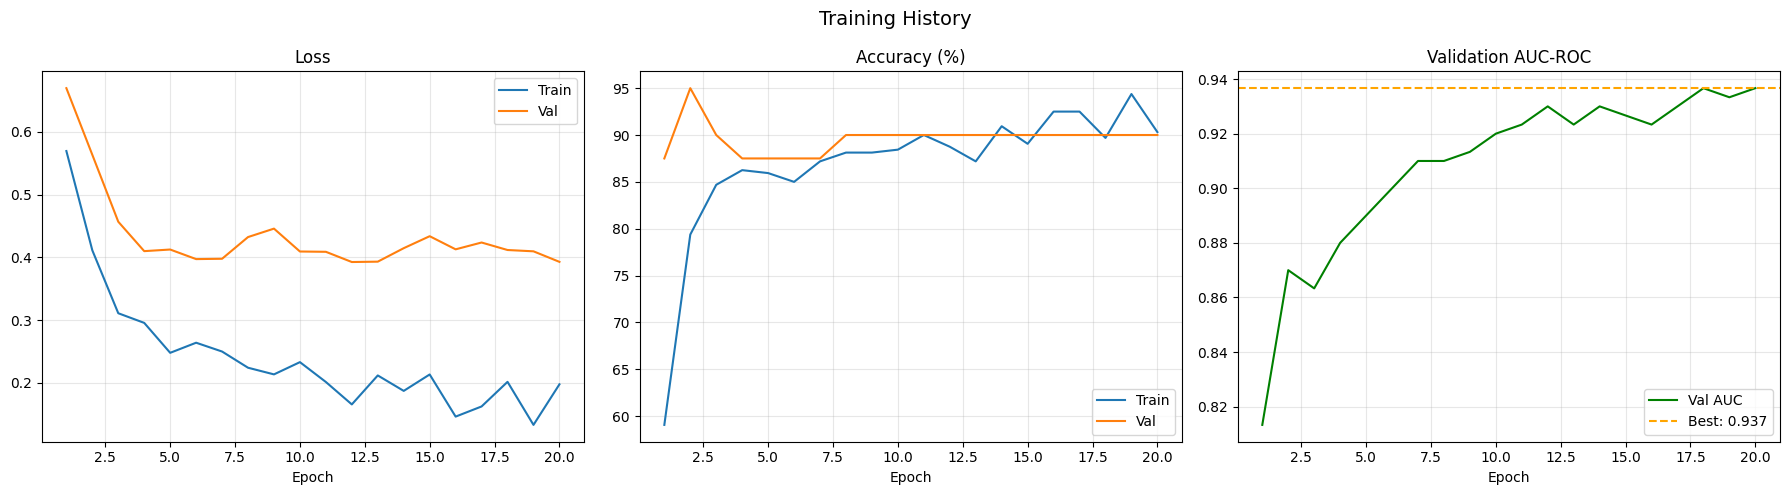

In [12]:
epochs_range = range(1, EPOCHS + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training History', fontsize=14)

axes[0].plot(epochs_range, history['train_loss'], label='Train')
axes[0].plot(epochs_range, history['val_loss'],   label='Val')
axes[0].set_title('Loss'); axes[0].set_xlabel('Epoch'); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].plot(epochs_range, [a * 100 for a in history['train_acc']], label='Train')
axes[1].plot(epochs_range, [a * 100 for a in history['val_acc']],   label='Val')
axes[1].set_title('Accuracy (%)'); axes[1].set_xlabel('Epoch'); axes[1].legend(); axes[1].grid(alpha=0.3)

axes[2].plot(epochs_range, history['val_auc'], color='green', label='Val AUC')
axes[2].axhline(best_val_auc, color='orange', linestyle='--', label=f'Best: {best_val_auc:.3f}')
axes[2].set_title('Validation AUC-ROC'); axes[2].set_xlabel('Epoch'); axes[2].legend(); axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Evaluation

In [13]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(DEVICE))
        probs   = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds   = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_probs.extend(probs)

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

print('Classification Report (Test Set)')
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))
print(f'AUC-ROC: {roc_auc_score(all_labels, all_probs):.4f}')

Classification Report (Test Set)
              precision    recall  f1-score   support

      Normal       0.83      0.97      0.89        30
    Cataract       0.80      0.40      0.53        10

    accuracy                           0.82        40
   macro avg       0.81      0.68      0.71        40
weighted avg       0.82      0.82      0.80        40

AUC-ROC: 0.9233


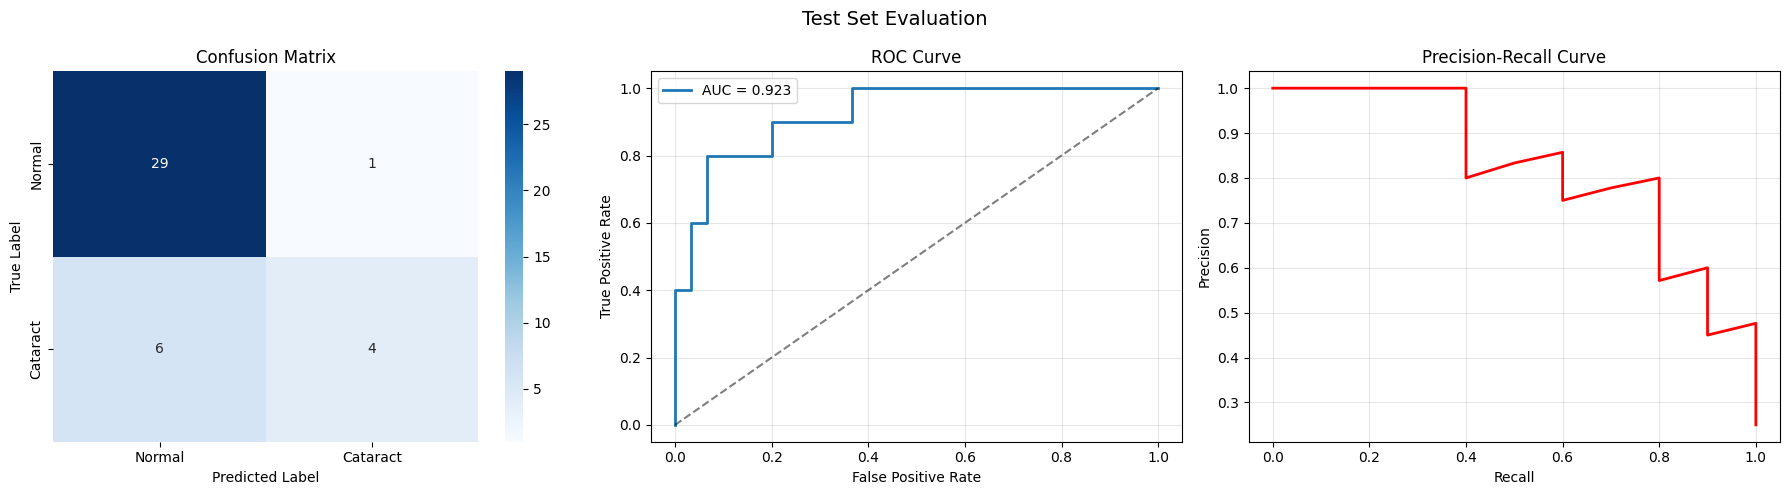

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Test Set Evaluation', fontsize=14)

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label'); axes[0].set_xlabel('Predicted Label')

fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score   = roc_auc_score(all_labels, all_probs)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {auc_score:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate'); axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve'); axes[1].legend(); axes[1].grid(alpha=0.3)

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
axes[2].plot(recall, precision, lw=2, color='red')
axes[2].set_xlabel('Recall'); axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve'); axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

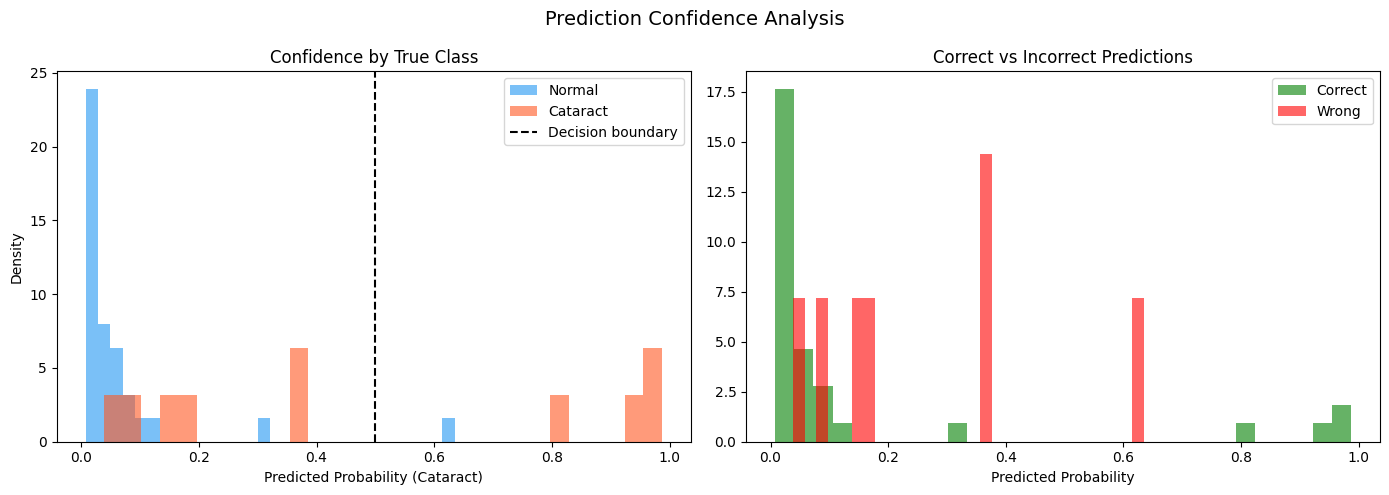

Test Accuracy: 82.50%  AUC: 0.9233  F1: 0.5333


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Prediction Confidence Analysis', fontsize=14)

for cls_idx, cls_name in enumerate(CLASS_NAMES):
    axes[0].hist(all_probs[all_labels == cls_idx], bins=30, alpha=0.6,
                 label=cls_name, color=COLORS[cls_idx], density=True)
axes[0].axvline(0.5, color='black', linestyle='--', label='Decision boundary')
axes[0].set_xlabel('Predicted Probability (Cataract)')
axes[0].set_ylabel('Density')
axes[0].set_title('Confidence by True Class'); axes[0].legend()

correct_mask = all_preds == all_labels
axes[1].hist(all_probs[correct_mask],  bins=30, alpha=0.6, color='green', label='Correct', density=True)
axes[1].hist(all_probs[~correct_mask], bins=30, alpha=0.6, color='red',   label='Wrong',   density=True)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_title('Correct vs Incorrect Predictions'); axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Test Accuracy: {(all_preds == all_labels).mean():.2%}  AUC: {auc_score:.4f}  F1: {f1_score(all_labels, all_preds):.4f}')

## 7. Grad-CAM Visualization

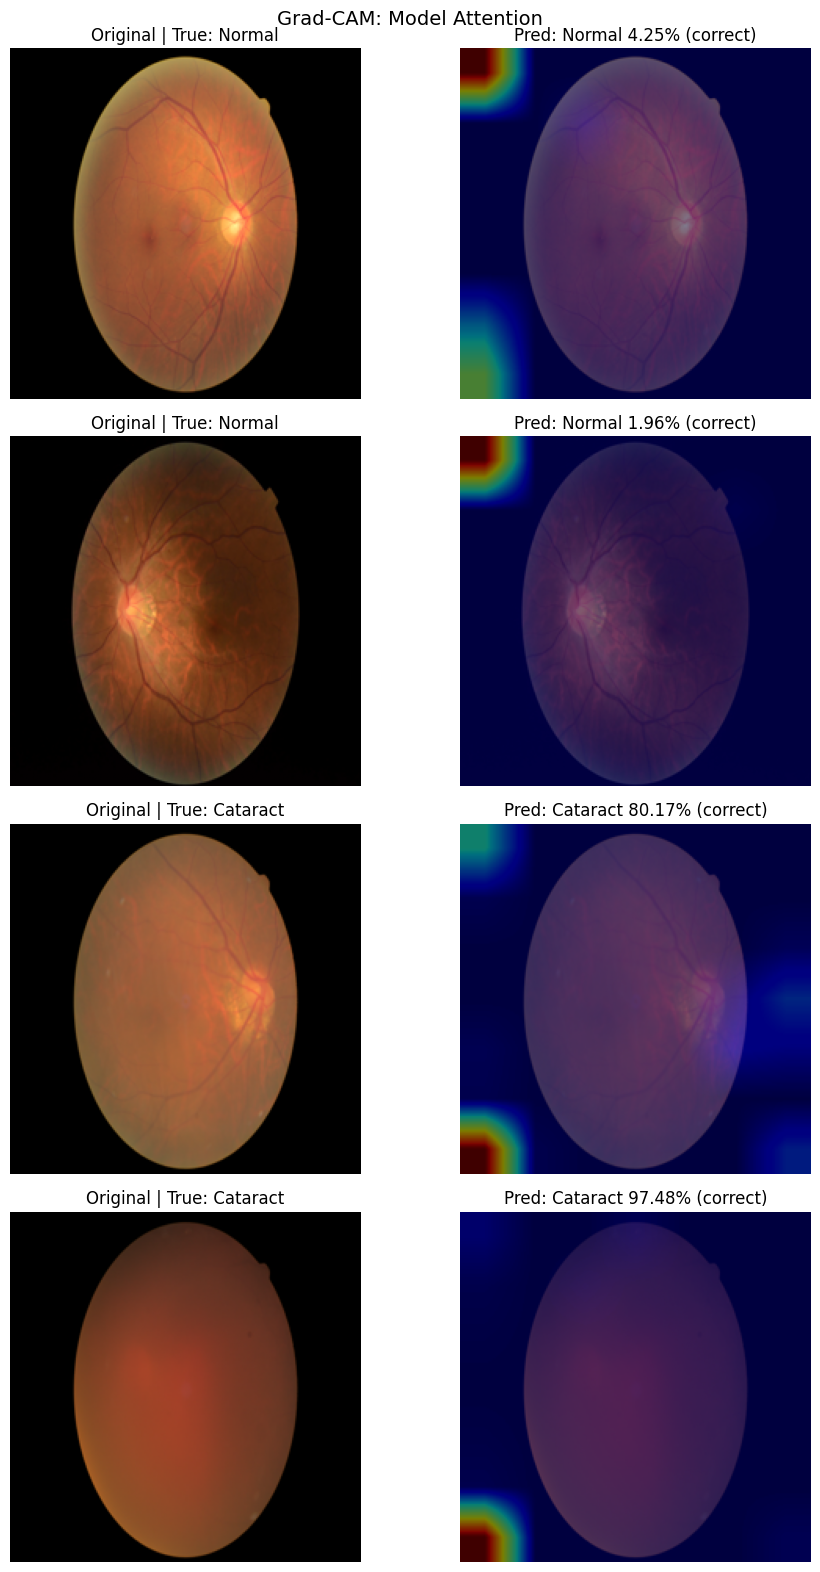

In [16]:
import cv2


class GradCAM:
    def __init__(self, model, target_layer):
        self.model       = model
        self.gradients   = None
        self.activations = None
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam     = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam     = cam - cam.min()
        cam     = cam / (cam.max() + 1e-8)
        return cam.squeeze().cpu().numpy(), class_idx


target_layer = model.backbone.blocks[-1][-1].conv_pw
grad_cam     = GradCAM(model, target_layer)


def run_grad_cam(img_path, true_label):
    img_orig   = Image.open(img_path).convert('RGB')
    img_tensor = val_transforms(img_orig).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad_(True)
    cam, pred_idx = grad_cam(img_tensor)
    prob          = torch.softmax(model(img_tensor), dim=1)[0, 1].item()
    cam_resized   = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    heatmap       = plt.cm.jet(cam_resized)[:, :, :3]
    img_arr       = np.array(img_orig.resize((IMG_SIZE, IMG_SIZE))) / 255.0
    overlay       = np.clip(0.5 * img_arr + 0.5 * heatmap, 0, 1)
    return img_arr, overlay, prob, CLASS_NAMES[pred_idx], CLASS_NAMES[true_label]


cam_samples = pd.concat([
    test_df[test_df['class'] == 'Normal'].sample(2, random_state=SEED),
    test_df[test_df['class'] == 'Cataract'].sample(2, random_state=SEED)
]).reset_index(drop=True)

fig, axes = plt.subplots(4, 2, figsize=(10, 16))
fig.suptitle('Grad-CAM: Model Attention', fontsize=14)

for i, (_, row) in enumerate(cam_samples.iterrows()):
    img_arr, overlay, prob, pred_cls, true_cls = run_grad_cam(row['path'], row['label'])
    marker = '(correct)' if pred_cls == true_cls else '(wrong)'
    axes[i][0].imshow(img_arr)
    axes[i][0].set_title(f'Original | True: {true_cls}'); axes[i][0].axis('off')
    axes[i][1].imshow(overlay)
    axes[i][1].set_title(f'Pred: {pred_cls} {prob:.2%} {marker}'); axes[i][1].axis('off')

plt.tight_layout()
plt.show()

## 8. Inference

In [17]:
def predict(image_path, threshold=0.5):
    model.eval()
    img    = Image.open(image_path).convert('RGB')
    tensor = val_transforms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        probs = torch.softmax(model(tensor), dim=1)[0].cpu().numpy()
    cataract_prob   = float(probs[1])
    predicted_class = 'Cataract' if cataract_prob >= threshold else 'Normal'
    confidence      = cataract_prob if predicted_class == 'Cataract' else 1 - cataract_prob
    return {'predicted_class': predicted_class, 'cataract_probability': cataract_prob,
            'normal_probability': float(probs[0]), 'confidence': confidence}


demo = test_df.groupby('class').apply(lambda x: x.sample(3, random_state=SEED)).reset_index(drop=True)
rows = []
for _, row in demo.iterrows():
    pred = predict(row['path'])
    rows.append({'true': row['class'], 'predicted': pred['predicted_class'],
                 'cataract_prob': f"{pred['cataract_probability']:.2%}",
                 'confidence':    f"{pred['confidence']:.2%}",
                 'correct':       'yes' if pred['predicted_class'] == row['class'] else 'no'})

print(pd.DataFrame(rows).to_string(index=False))

    true predicted cataract_prob confidence correct
Cataract  Cataract        80.17%     80.17%     yes
Cataract  Cataract        97.48%     97.48%     yes
Cataract  Cataract        98.71%     98.71%     yes
  Normal    Normal         4.25%     95.75%     yes
  Normal    Normal         1.96%     98.04%     yes
  Normal    Normal         1.74%     98.26%     yes


## 9. Model Export

Four formats are exported:

| File | Use case |
|---|---|
| `model_weights.pth` | Reload in Python with `CataractClassifier` class |
| `model_full.pth` | Quick reload — no class definition needed (`torch.load`) |
| `model_scripted.pt` | TorchScript — portable, no Python class needed at runtime |
| `model.onnx` | ONNX Runtime, OpenCV DNN, TensorRT, mobile deployment |
| `model_config.json` | Preprocessing params (mean, std, img_size, class names) |

In [18]:
EXPORT_DIR = Path('/kaggle/working/exported_model')
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), EXPORT_DIR / 'model_weights.pth')
torch.save(model, EXPORT_DIR / 'model_full.pth')

model_config = {
    'backbone':      'efficientnet_b3',
    'num_classes':   2,
    'class_names':   CLASS_NAMES,
    'img_size':      IMG_SIZE,
    'dropout':       0.4,
    'imagenet_mean': IMAGENET_MEAN,
    'imagenet_std':  IMAGENET_STD
}
with open(EXPORT_DIR / 'model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print('Saved: model_weights.pth, model_full.pth, model_config.json')

Saved: model_weights.pth, model_full.pth, model_config.json


In [19]:
!pip install onnxscript onnx onnxruntime -q

dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
onnx_path   = str(EXPORT_DIR / 'model.onnx')

model.eval()
torch.onnx.export(
    model.cpu(),
    dummy_input.cpu(),
    onnx_path,
    export_params=True,
    opset_version=13,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)
model.to(DEVICE)
print(f'ONNX model saved: {onnx_path}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 11.8 MB/s eta 0:00:00


W0221 15:02:36.205000 24 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 13 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
W0221 15:02:37.122000 24 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0221 15:02:37.124000 24 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, ali

[torch.onnx] Obtain model graph for `CataractClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CataractClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 13).


[torch.onnx] Translate the graph into ONNX... ✅


Failed to convert the model to the target version 13 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 120, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 115, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Runtim

Applied 158 of general pattern rewrite rules.
ONNX model saved: /kaggle/working/exported_model/model.onnx


In [20]:
# Remove all hooks before tracing (Grad-CAM registered backward hooks on the model)
for module in model.modules():
    module._backward_hooks.clear()
    module._forward_hooks.clear()

model.eval()
dummy_input  = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
traced_model = torch.jit.trace(model, dummy_input)
script_path  = str(EXPORT_DIR / 'model_traced.pt')
traced_model.save(script_path)
print(f'TorchScript (traced) model saved: {script_path}')

with torch.no_grad():
    original_out = model(dummy_input)
    traced_out   = traced_model(dummy_input)
    print(f'Max output difference: {(original_out - traced_out).abs().max().item():.2e}')

TorchScript (traced) model saved: /kaggle/working/exported_model/model_traced.pt
Max output difference: 1.79e-07


In [21]:
import onnxruntime as ort
import onnx

onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

ort_session = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])

test_img    = val_transforms(Image.open(test_df.iloc[0]['path']).convert('RGB')).unsqueeze(0)
pt_probs    = torch.softmax(model(test_img.to(DEVICE)), dim=1)[0].detach().cpu().numpy()
onnx_out    = ort_session.run(None, {'input': test_img.numpy()})[0]
onnx_probs  = torch.softmax(torch.tensor(onnx_out), dim=1)[0].numpy()

print('PyTorch probs:', pt_probs.round(4))
print('ONNX probs:   ', onnx_probs.round(4))
print('Max diff:     ', abs(pt_probs - onnx_probs).max())

PyTorch probs: [0.9802 0.0198]
ONNX probs:    [0.9802 0.0198]
Max diff:      1.4901161e-08


In [22]:
with open(EXPORT_DIR / 'model_config.json') as f:
    cfg = json.load(f)

loaded_model = CataractClassifier(num_classes=cfg['num_classes'], pretrained=False)
loaded_model.load_state_dict(torch.load(EXPORT_DIR / 'model_weights.pth', map_location='cpu'))
loaded_model.eval()

print('Model reloaded from weights.')
print('Classes:', cfg['class_names'])

Model reloaded from weights.
Classes: ['Normal', 'Cataract']


In [23]:
print('Exported files:')
for f in sorted(EXPORT_DIR.iterdir()):
    print(f'  {f.name:<30} {f.stat().st_size / 1e6:.1f} MB')

Exported files:
  model.onnx                     1.0 MB
  model.onnx.data                46.3 MB
  model_config.json              0.0 MB
  model_full.pth                 47.8 MB
  model_traced.pt                47.6 MB
  model_weights.pth              46.8 MB
